# Importing Required libraries

In [1]:
import cv2
import mediapipe as mp
import csv
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import shutil

In [2]:
# Initialize MediaPipe Pose and Drawing utilities
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

# <B>INITIALIZE DIRECTORY PATH

In [15]:
#DATASET_DIR = 'Single_person_violent'
DATASET_DIR = 'Final_Dataset_trim'
ADDITIONAL_DIR = 'Additional_Dataset'
# Action List
CLASSES_LIST = ['Jump',
 'Left High Kick',
 #'Idle',
 'Punch Left',
 #'Uppercut',
 'Block',
 'Duck',
 #'Stance',
 'Punch Right',
 'Right Low Kick',
 'Right High Kick',
 'Left Low Kick']

# Directory to save csv files
OUTPUT_DIR = 'Output'

# Dataframe column header for a single video
custom_headers = ['Frame Number', 'x','y','z','Visibility']

## Normalize landmarks while creating dataset csv from videos

In [4]:
def normalize_z_values(landmarks):
    """
    Normalize the z-values of all pose landmarks(0-33) to a range of [0, 1].

    Parameters:
    landmarks (list): List of pose landmarks, each represented as [x, y, z, visibility].

    Returns:
    list: Normalized pose landmarks with z-values scaled to [0, 1].
    """
    if not landmarks: return landmarks

    min_z = -2
    max_z = 2

    
    # Normalize z-values to range [0, 1]
    normalized_landmarks = []
    for lm in landmarks:
        if max_z - min_z != 0:
            normalized_z = (lm[3] - min_z) / (max_z - min_z)
        else:
            normalized_z = lm[3]  # Handle edge case
        # Replace with the desired visibility value
        
        normalized_landmarks.append([lm[0], lm[1],lm[2], normalized_z, lm[4]])  # Keep x, y, visibility unchanged
        # else:
        #     normalized_landmarks.append([-1,-1,-1,-1])

    return normalized_landmarks

## CONVERT VIDEO INTO POSE LANDMARKS
##### Uses the write_landmarks_to_csv function to add the landmarks of all frames of a video to a csv

In [8]:
# Convert a video into landmarks using mediapipe
def convert_video_to_landmark_csv(video_path):
    frame_number = 0
    csv_data = []
    exclude_points = [1,2,3,4,5,6,7,8,9,10]
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    with mp_pose.Pose(min_detection_confidence=0.6, min_tracking_confidence=0.6) as pose:
        while cap.isOpened():            
            ret, frame = cap.read()
            if not ret:
                break
            frame_number += 1
            # Convert the image to RGB
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False

            # Perform pose detection
            results = pose.process(image)

            # Convert the image back to BGR
            # image.flags.writeable = True
            # image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)          

            # Draw the pose annotation on the image
            # if results.pose_landmarks:
            #     mp_drawing.draw_landmarks(
            #         image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

            if results.pose_landmarks:
                # Add the required landmark coordinates to the list     
                temp_csv = []       
                for idx,landmark in enumerate(results.pose_landmarks.landmark):                
                    if idx not in exclude_points:                            
                        #print(f"{mp_pose.PoseLandmark(idx).name}: (x: {landmark.x}, y: {landmark.y}, z: {landmark.z})")
                        temp_csv.append([frame_number, landmark.x, landmark.y, landmark.z,landmark.visibility])     
                temp_csv = normalize_z_values(temp_csv)
                csv_data.extend(temp_csv)
            
    cap.release() 

    # Extract folder and class names from the video path
    file_name = os.path.splitext(os.path.basename(video_path))[0]
    class_name = os.path.basename(os.path.dirname(video_path))
        
    # Ensure the output directory exists
    output_file_dir = os.path.join(OUTPUT_DIR, class_name)        
    os.makedirs(output_file_dir, exist_ok=True)  

    output_file = os.path.join(output_file_dir, f'{file_name}.csv')

    counter = 1

    # Check if the file already exists and find a new filename if it does        
    new_path = output_file
    while os.path.exists(new_path):
        new_path = f'{output_file[:-4]} ({counter}).csv'
        counter += 1
    
    output_file = new_path    

    with open(f'{output_file}', mode='w', newline='') as file:
        writer = csv.writer(file)
        # Write each row of the 2D array
        for row in csv_data:
            writer.writerow(row)

In [66]:
convert_video_to_landmark_csv(r'D:\Programming\AI\Open CV\Mediapipe\Additional_Dataset\Duck\duck (1).mp4')

c:\Users\Ankit\AppData\Local\Programs\Python\Python311\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


# Convert all videos in the given CLASSES_LIST into landmark csv files

In [6]:
# Convert all videos in the given CLASSES_LIST into landmark csv files
def create_dataset(dir,CLASSES_LIST):
    print('List: ',CLASSES_LIST)
    for class_name in CLASSES_LIST:
        print(f"Extracting data from {class_name} from {dir}")
        # Get list of videos for each class
        files_list = os.listdir(os.path.join(dir, class_name))
        for file_name in files_list:
            # Get the complete video path.
            video_file_path = os.path.join(dir, class_name, file_name)
            convert_video_to_landmark_csv(video_file_path)

In [14]:
def copyVideosFromAdditionalToDatasetDir(CLASSES_LIST):
    for class_name in CLASSES_LIST:
        # Construct the source directory path for the current class
        class_source_dir = os.path.join(ADDITIONAL_DIR, class_name)

        # Check if the class directory exists
        if not os.path.exists(class_source_dir):
            print(f"Directory {class_source_dir} does not exist. Skipping...")
            continue
        # Get list of videos for each class
        files_list = os.listdir(class_source_dir)
        for file_name in files_list:
            # Get the complete video path.
            video_file_path = os.path.join(class_source_dir, file_name)
            destination_path = os.path.join(DATASET_DIR, class_name,file_name)
            # Check if the file already exists in the destination directory
            if os.path.exists(destination_path):
                base_name, extension = os.path.splitext(file_name)
                counter = 1
                while os.path.exists(destination_path):
                    new_file_name = f"{base_name} ({counter}){extension}"
                    destination_path = os.path.join(DATASET_DIR,class_name, new_file_name)
                    counter += 1
            shutil.copy(video_file_path, destination_path)

In [15]:
copyVideosFromAdditionalToDatasetDir(CLASSES_LIST)

In [9]:
create_dataset(ADDITIONAL_DIR,CLASSES_LIST)

List:  ['Jump', 'Left High Kick', 'Idle', 'Punch Left', 'Uppercut', 'Block', 'Duck', 'Stance', 'Punch Right', 'Right Low Kick', 'Right High Kick', 'Left Low Kick']
Extracting data from Jump from Additional_Dataset


c:\Users\Ankit\AppData\Local\Programs\Python\Python311\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Extracting data from Left High Kick from Additional_Dataset
Extracting data from Idle from Additional_Dataset
Extracting data from Punch Left from Additional_Dataset
Extracting data from Uppercut from Additional_Dataset
Extracting data from Block from Additional_Dataset
Extracting data from Duck from Additional_Dataset
Extracting data from Stance from Additional_Dataset
Extracting data from Punch Right from Additional_Dataset
Extracting data from Right Low Kick from Additional_Dataset
Extracting data from Right High Kick from Additional_Dataset
Extracting data from Left Low Kick from Additional_Dataset


# Create a sequence from a CSV file for making a single row

In [8]:
# Create a sequence from a CSV file for making a single dataframe
def createSequence(csv_path):
    custom_headers = ['Frame Number', 'x', 'y', 'z', 'Visibility']
    data = pd.read_csv(csv_path, header=None, names=custom_headers)

    # Ensure all data is numeric and convert to float32
    data[['x', 'y', 'z', 'Visibility']] = data[['x', 'y', 'z', 'Visibility']].astype('float32')

    grouped = data.groupby('Frame Number')[['x', 'y', 'z', 'Visibility']].apply(lambda x: x.values.tolist())
    sequence = grouped.tolist()
    return sequence


#### Testing

In [58]:
# Read data from CSV and append to processed_df
sequence = createSequence('output.csv')
processed_df = pd.DataFrame([sequence])
#processed_df2 = processed_df.append(pd.DataFrame(frame, columns=['x', 'y', 'z', 'Visibility']), ignore_index=True)
processed_df.head()

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,Kicking,"[[0.4208270311355591, 0.2813926935195923, -0.5...","[[0.4226616024971008, 0.2830023467540741, -0.4...","[[0.422335147857666, 0.2832168936729431, -0.48...","[[0.4239648282527923, 0.2812423706054687, -0.2...","[[0.4259682595729828, 0.2790455818176269, -0.2...","[[0.424310564994812, 0.2764437794685364, -0.26...","[[0.424225777387619, 0.2755632400512695, 0.049...","[[0.4241669476032257, 0.2759043276309967, -0.1...","[[0.4190621674060821, 0.2758240699768066, -0.0...",...,"[[0.4902646839618683, 0.266271561384201, -0.52...","[[0.4924321174621582, 0.2656450271606445, -0.5...","[[0.4942595660686493, 0.2644723653793335, -0.5...","[[0.4932672381401062, 0.2639179527759552, -0.5...","[[0.4929601550102234, 0.264041006565094, -0.53...","[[0.4959222972393036, 0.2640158534049988, -0.5...","[[0.5004463791847229, 0.2640080451965332, -0.5...","[[0.5007750391960144, 0.2638412415981293, -0.4...","[[0.4997018575668335, 0.2627485990524292, -0.4...","[[0.4992328286170959, 0.262261152267456, -0.44..."


In [64]:
dat = pd.read_csv('output.csv',header=None,names=custom_headers)
dat['Frame Number'].tail(1).values[0]
#print(dat.groupby('FrameNumber')['x'].apply(lambda x: x.tolist()).iloc[:1][1])

37

In [13]:
# Get all the CSV files of the given CLASSES_LIST
def getAllCSV(CLASSES_LIST):
    files = {}
    for class_name in CLASSES_LIST:        
        # Get list of csv files for each class
        files_list = os.listdir(os.path.join(OUTPUT_DIR, class_name))
        for file_name in files_list:
            # Get the complete csv path.
            files.setdefault(class_name,[]).append(os.path.join(OUTPUT_DIR, class_name, file_name))
    return files

In [10]:
# Merge all the sequences into a single dataframe and return it
def createDataframe():
    df_array = []
    labels = []
    for class_name in CLASSES_LIST:
        # Get list of csv files for each class
        files_list = os.listdir(os.path.join(OUTPUT_DIR, class_name))
        for file_name in files_list:
            # Get the complete csv path.
            csv_file_path = os.path.join(OUTPUT_DIR, class_name, file_name)
            df_array.append(createSequence(csv_file_path))
            labels.append(CLASSES_LIST.index(class_name))
    return df_array, labels
            

In [10]:
# Calculate the mean and standard deviation of z values (depth values)
def calculateZParamsForNormalization(CLASSES_LIST,csv_files):    
    z_values = []
    for key in CLASSES_LIST:
        for file in csv_files[key]:
            df = pd.read_csv(file,header=None,names=custom_headers)
            z_values.extend(df['z'].values)
    z_mean = np.mean(z_values)
    z_std = np.std(z_values)
    return z_mean, z_std

In [18]:
# Calculate the min and max of z values (depth values)
def calculateZMinMaxForNormalization(CLASSES_LIST):    
    csv_files = getAllCSV(CLASSES_LIST)
    z_values = []
    for key in CLASSES_LIST:
        for file in csv_files[key]:
            df = pd.read_csv(file,header=None,names=custom_headers)
            z_values.extend(df['z'].values)
    z_min = np.min(z_values)
    z_max = np.max(z_values)
    return z_min, z_max

In [11]:
# Normalize all the z values (depth values) in the CSV files
def normalizeZValuesInCSV(CLASSES_LIST):    
    files = getAllCSV(CLASSES_LIST)
    z_min, z_max = -2,2
    for key in files:
        for file in files[key]:
            df = pd.read_csv(file,header=None,names=custom_headers)
            # Normalize the 'z' column using Min-Max scaling
            df['z'] = (df['z'] - z_min) / (z_max - z_min)
            df.to_csv(file, index=False, header=False)

In [14]:
def findHighestFrameNumber(CLASSES_LIST):
    highest_frame_number = 0    
    files = getAllCSV(CLASSES_LIST)        
    highest_frame_video = ''
    for key in files:        
        for file in files[key]:            
            df = pd.read_csv(file,header=None,names=custom_headers)
            current_frame_number = df['Frame Number'].tail(1).values[0]
            if  current_frame_number > highest_frame_number:
                highest_frame_number = current_frame_number  
                highest_frame_video  = file      
    return highest_frame_number,highest_frame_video

In [34]:
def findFramesHigherThanX(CLASSES_LIST,X):        
    files = getAllCSV(CLASSES_LIST)        
    high_frame_videos = []
    for key in files:        
        for file in files[key]:            
            df = pd.read_csv(file,header=None,names=custom_headers)
            current_frame_number = df['Frame Number'].tail(1).values[0]
            if  current_frame_number > X:
                high_frame_videos.append((file,current_frame_number))
    return high_frame_videos

In [36]:
def getAllCSVFrameCount(CLASSES_LIST):
    files = getAllCSV(CLASSES_LIST)
    frame_count = []
    for key in files:        
        for file in files[key]:            
            df = pd.read_csv(file,header=None,names=custom_headers)
            current_frame_number = df['Frame Number'].tail(1).values[0]
            frame_count.append(current_frame_number)
    return frame_count

In [16]:
def deleteFramesHigherThanX(CLASSES_LIST,X):        
    files = getAllCSV(CLASSES_LIST)        
    for key in files:        
        for file in files[key]:            
            df = pd.read_csv(file,header=None,names=custom_headers)
            current_frame_number = df['Frame Number'].tail(1).values[0]
            if  current_frame_number > X:
                os.remove(file)

In [37]:
frame_count = getAllCSVFrameCount(CLASSES_LIST)

Text(0, 0.5, 'Frequency')

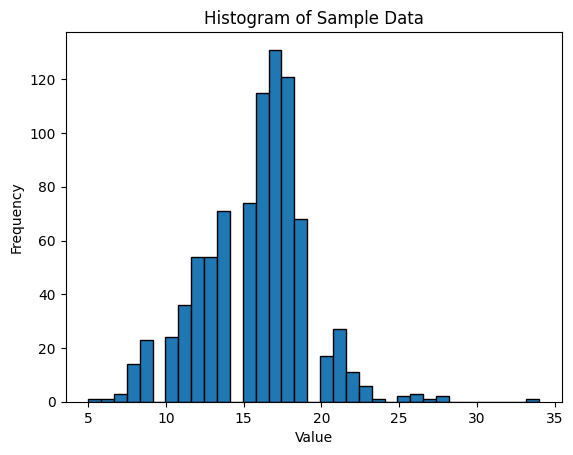

In [43]:
# Create a histogram
plt.hist(frame_count, bins=35, edgecolor='black')

# Add titles and labels
plt.title('Histogram of Sample Data')
plt.xlabel('Value')
plt.ylabel('Frequency')

In [17]:
create_dataset(CLASSES_LIST)

List:  ['Idle', 'Block', 'Kicking', 'Punching']
Extracting data from Idle
Extracting data from Block
Extracting data from Kicking
Extracting data from Punching


In [20]:
calculateZMinMaxForNormalization(CLASSES_LIST)

(-1.840239405632019, 1.3689271211624146)

In [14]:
normalizeZValuesInCSV(CLASSES_LIST)

In [35]:
high_frame_videos = findFramesHigherThanX(CLASSES_LIST,25)
high_frame_videos

[('Output\\Left High Kick\\kick24a - Trim.csv', 34),
 ('Output\\Left High Kick\\kick_left6 - Trim.csv', 26),
 ('Output\\Uppercut\\uppercut.csv', 26),
 ('Output\\Duck\\duck (14).csv', 28),
 ('Output\\Right Low Kick\\right_low_kick (5).csv', 27),
 ('Output\\Right High Kick\\kick_right13 - Trim.csv', 28),
 ('Output\\Right High Kick\\kick_right14 - Trim.csv', 26)]

In [84]:
deleteFramesHigherThanX(CLASSES_LIST,100)

In [32]:
highestFrameNumber, highestFrameVideo = findHighestFrameNumber(CLASSES_LIST)            

In [33]:
highestFrameNumber, highestFrameVideo

(34, 'Output\\Left High Kick\\kick24a - Trim.csv')

In [34]:
complete_df = createDataframe(CLASSES_LIST)

In [39]:
complete_df.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,Idle,"[[0.4748861193656921, 0.3235374391078949, 0.42...","[[0.4748989641666412, 0.325264424085617, 0.447...","[[0.4749002456665039, 0.3261786103248596, 0.44...","[[0.4748976826667785, 0.3267720639705658, 0.45...","[[0.4748576283454895, 0.3271466195583343, 0.45...","[[0.4747265875339508, 0.3272871673107147, 0.45...","[[0.4746758341789245, 0.3274039626121521, 0.45...","[[0.4746645987033844, 0.3274757266044616, 0.44...","[[0.4746582508087158, 0.3276874125003814, 0.44...",...,"[[0.4746448099613189, 0.3281348943710327, 0.44...","[[0.4746478199958801, 0.3282523453235626, 0.44...","[[0.4746401906013489, 0.3283793032169342, 0.44...","[[0.4746378362178802, 0.3284424245357513, 0.43...","[[0.4746374487876892, 0.3284406661987304, 0.44...","[[0.4746530950069427, 0.3284560739994049, 0.44...",None,None,None,None
1,Idle,"[[0.5404775142669678, 0.2541113197803497, 0.45...","[[0.5398675799369812, 0.2529995143413543, 0.42...","[[0.5397141575813293, 0.2522099614143371, 0.41...","[[0.5392981767654419, 0.2517683506011963, 0.42...","[[0.538953959941864, 0.2514675557613373, 0.420...","[[0.538551390171051, 0.2514175176620483, 0.417...","[[0.5384813547134399, 0.2514233589172363, 0.41...","[[0.5384558439254761, 0.2514885067939758, 0.41...","[[0.5384582281112671, 0.2517432868480682, 0.41...",...,"[[0.5384629964828491, 0.2519022226333618, 0.40...","[[0.5384476780891418, 0.2519340813159942, 0.40...","[[0.5383436679840088, 0.2519429326057434, 0.40...","[[0.5383172631263733, 0.2519051730632782, 0.40...","[[0.5382704734802246, 0.2518979609012604, 0.40...","[[0.5379912853240967, 0.2518975436687469, 0.40...",None,None,None,None
2,Idle,"[[0.542168915271759, 0.2527251839637756, 0.407...","[[0.5427751541137695, 0.2537916302680969, 0.39...","[[0.543321967124939, 0.2539032995700836, 0.394...","[[0.5436407327651978, 0.2538996636867523, 0.39...","[[0.5437939763069153, 0.2540659010410309, 0.39...","[[0.5441200137138367, 0.2540866732597351, 0.39...","[[0.5445000529289246, 0.2543652951717376, 0.39...","[[0.5447270274162292, 0.2545829117298126, 0.39...","[[0.5449918508529663, 0.2546611726284027, 0.39...",...,"[[0.5451918840408325, 0.2554073631763458, 0.39...","[[0.545242428779602, 0.2556852996349334, 0.390...","[[0.545291543006897, 0.2566145360469818, 0.388...","[[0.5453301668167114, 0.2571437358856201, 0.38...","[[0.5454679131507874, 0.2575704157352447, 0.38...","[[0.545543372631073, 0.2577041685581207, 0.386...",None,None,None,None
3,Idle,"[[0.5349584221839905, 0.2530511915683746, 0.42...","[[0.5358224511146545, 0.2556289434432983, 0.40...","[[0.5361714363098145, 0.2576116323471069, 0.40...","[[0.5364331007003784, 0.2587653398513794, 0.40...","[[0.5364265441894531, 0.2594764828681946, 0.40...","[[0.5362555980682373, 0.2594317197799682, 0.40...","[[0.5362435579299927, 0.2594682872295379, 0.40...","[[0.5361764430999756, 0.2598654329776764, 0.40...","[[0.5361486673355103, 0.2602948844432831, 0.40...",...,"[[0.5359793901443481, 0.2602251470088959, 0.40...","[[0.5359129309654236, 0.2602929770946502, 0.40...","[[0.535770058631897, 0.2602910101413727, 0.408...","[[0.5354559421539307, 0.2605333030223846, 0.40...","[[0.5353894829750061, 0.2606146931648254, 0.41...","[[0.5352891087532043, 0.2608326077461242, 0.41...",None,None,None,None
4,Idle,"[[0.5507176518440247, 0.2603665590286255, 0.39...","[[0.5507181882858276, 0.2601602673530578, 0.41...","[[0.5507670640945435, 0.260135680437088, 0.416...","[[0.5507688522338867, 0.2601229548454284, 0.41...","[[0.5508307218551636, 0.260075569152832, 0.417...","[[0.550967812538147, 0.2600583434104919, 0.418...","[[0.5512138605117798, 0.260050892829895, 0.418...","[[0.5512937307357788, 0.2600233256816864, 0.41...","[[0.5512953996658325, 0.2599594593048095, 0.41...",...,"[[0.5510843992233276, 0.2599212229251861, 0.41...","[[0.5510178208351135, 0.2599170207977295, 0.41...","[[0.5506752133369446, 0.259879320859909, 0.410...","[[0.5503283739089966, 0.2597333490848541, 0.40...","[[0.549990594

## Only keep 20 frames of data

In [38]:
# Remove columns after 20 frames
complete_df = complete_df.iloc[:, :20+1]

In [40]:
labels = complete_df[0]
labels

0          Idle
1          Idle
2          Idle
3          Idle
4          Idle
         ...   
176    Punching
177    Punching
178    Punching
179    Punching
180    Punching
Name: 0, Length: 181, dtype: object

In [41]:
features = complete_df.drop(0, axis=1)
features

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,"[[0.4748861193656921, 0.3235374391078949, 0.42...","[[0.4748989641666412, 0.325264424085617, 0.447...","[[0.4749002456665039, 0.3261786103248596, 0.44...","[[0.4748976826667785, 0.3267720639705658, 0.45...","[[0.4748576283454895, 0.3271466195583343, 0.45...","[[0.4747265875339508, 0.3272871673107147, 0.45...","[[0.4746758341789245, 0.3274039626121521, 0.45...","[[0.4746645987033844, 0.3274757266044616, 0.44...","[[0.4746582508087158, 0.3276874125003814, 0.44...","[[0.4746465682983398, 0.3279991447925567, 0.44...","[[0.4746448099613189, 0.3281348943710327, 0.44...","[[0.4746478199958801, 0.3282523453235626, 0.44...","[[0.4746401906013489, 0.3283793032169342, 0.44...","[[0.4746378362178802, 0.3284424245357513, 0.43...","[[0.4746374487876892, 0.3284406661987304, 0.44...","[[0.4746530950069427, 0.3284560739994049, 0.44...",None,None,None,None
1,"[[0.5404775142669678, 0.2541113197803497, 0.45...","[[0.5398675799369812, 0.2529995143413543, 0.42...","[[0.5397141575813293, 0.2522099614143371, 0.41...","[[0.5392981767654419, 0.2517683506011963, 0.42...","[[0.538953959941864, 0.2514675557613373, 0.420...","[[0.538551390171051, 0.2514175176620483, 0.417...","[[0.5384813547134399, 0.2514233589172363, 0.41...","[[0.5384558439254761, 0.2514885067939758, 0.41...","[[0.5384582281112671, 0.2517432868480682, 0.41...","[[0.5384827852249146, 0.2518951892852783, 0.40...","[[0.5384629964828491, 0.2519022226333618, 0.40...","[[0.5384476780891418, 0.2519340813159942, 0.40...","[[0.5383436679840088, 0.2519429326057434, 0.40...","[[0.5383172631263733, 0.2519051730632782, 0.40...","[[0.5382704734802246, 0.2518979609012604, 0.40...","[[0.5379912853240967, 0.2518975436687469, 0.40...",None,None,None,None
2,"[[0.542168915271759, 0.2527251839637756, 0.407...","[[0.5427751541137695, 0.2537916302680969, 0.39...","[[0.543321967124939, 0.2539032995700836, 0.394...","[[0.5436407327651978, 0.2538996636867523, 0.39...","[[0.5437939763069153, 0.2540659010410309, 0.39...","[[0.5441200137138367, 0.2540866732597351, 0.39...","[[0.5445000529289246, 0.2543652951717376, 0.39...","[[0.5447270274162292, 0.2545829117298126, 0.39...","[[0.5449918508529663, 0.2546611726284027, 0.39...","[[0.5451713800430298, 0.2547495663166046, 0.39...","[[0.5451918840408325, 0.2554073631763458, 0.39...","[[0.545242428779602, 0.2556852996349334, 0.390...","[[0.545291543006897, 0.2566145360469818, 0.388...","[[0.5453301668167114, 0.2571437358856201, 0.38...","[[0.5454679131507874, 0.2575704157352447, 0.38...","[[0.545543372631073, 0.2577041685581207, 0.386...",None,None,None,None
3,"[[0.5349584221839905, 0.2530511915683746, 0.42...","[[0.5358224511146545, 0.2556289434432983, 0.40...","[[0.5361714363098145, 0.2576116323471069, 0.40...","[[0.5364331007003784, 0.2587653398513794, 0.40...","[[0.5364265441894531, 0.2594764828681946, 0.40...","[[0.5362555980682373, 0.2594317197799682, 0.40...","[[0.5362435579299927, 0.2594682872295379, 0.40...","[[0.5361764430999756, 0.2598654329776764, 0.40...","[[0.5361486673355103, 0.2602948844432831, 0.40...","[[0.5361440777778625, 0.2602701783180237, 0.40...","[[0.5359793901443481, 0.2602251470088959, 0.40...","[[0.5359129309654236, 0.2602929770946502, 0.40...","[[0.535770058631897, 0.2602910101413727, 0.408...","[[0.5354559421539307, 0.2605333030223846, 0.40...","[[0.5353894829750061, 0.2606146931648254, 0.41...","[[0.5352891087532043, 0.2608326077461242, 0.41...",None,None,None,None
4,"[[0.5507176518440247, 0.2603665590286255, 0.39...","[[0.5507181882858276, 0.2601602673530578, 0.41...","[[0.5507670640945435, 0.260135680437088, 0.416...","[[0.5507688522338867, 0.2601229548454284, 0.41...","[[0.5508307218551636, 0.260075569152832, 0.417...","[[0.550967812538147, 0.2600583434104919, 0.418...","[[0.5512138605117798, 0.260050892829895, 0.418...","[[0.5512937307357788, 0.2600233256816864, 0.41...","[[0.5512953996658325, 0.2599594593048095, 0.41...","[[0.551196277141571, 0.2599247992038727, 0.415...","[[0.55108

In [ ]:
complete_df[complete_df.iloc[:,0] == 'Punching'][:5]

In [10]:
files = getAllCSV(CLASSES_LIST)

NameError: name 'getAllCSV' is not defined

In [ ]:
df2 = pd.read_csv('output.csv',header=None,names=custom_headers)
arr = []
arr.extend(df2['z'].values)
arr

In [12]:
z_mean, z_std = calculateZParamsForNormalization(CLASSES_LIST,files)

In [13]:
z_min, z_max = calculateZMinMaxForNormalization(CLASSES_LIST,files)

In [34]:
z_mean, z_std
#(-0.10812381639618134, 0.44725407070063944)

(0.5545347004295016, 0.09994274934490296)

In [28]:
z_min, z_max
#(-1.6407425403594973, 1.754867672920227)

(0.0, 1.0)

## Useless 

In [ ]:
# Just for renaming from .csv.csv to .csv
for class_name in CLASSES_LIST:        
    # Get list of csv files for each class
    files_list = os.listdir(os.path.join(OUTPUT_DIR, class_name))    
    for filename in files_list:
        if filename.endswith('.csv.csv'):
            folder_name = os.path.join(OUTPUT_DIR,class_name)
            # Construct the new filename by removing the extra .csv
            new_filename = os.path.join(folder_name, filename[:-4])
            # Rename the file
            os.rename(os.path.join(folder_name, filename), new_filename)
            print(f'Renamed {filename} to {filename[:-4]}')

In [18]:
model = tf.keras.models.load_model('models/model2v2.h5')

In [19]:
max_num_frames = 15  # maximum number of frames per action sequence
num_landmarks = 23    # number of landmarks per frame
num_features = 4      # number of features per landmark (x, y, z, visibility)
num_classes = len(CLASSES_LIST)       # number of action classes

In [20]:
CLASSES_LIST

['Jump',
 'Left High Kick',
 'Punch Left',
 'Block',
 'Duck',
 'Punch Right',
 'Right Low Kick',
 'Right High Kick',
 'Left Low Kick']

In [21]:
def preprocess_frame(results):
    # Extract landmarks and preprocess
    landmarks = []
    if results.pose_landmarks:
        for lm in results.pose_landmarks.landmark:
            landmarks.append([lm.x, lm.y, lm.z, lm.visibility])
    return landmarks

In [22]:
def predict_action(sequence):
    # Pad the sequence
    padded_sequence = pad_sequences([sequence], maxlen=max_num_frames, dtype='float32', padding='post', truncating='post', value=-1)
    padded_sequence = padded_sequence.reshape((padded_sequence.shape[0], padded_sequence.shape[1], num_landmarks * num_features))
    
    # Predict the action
    predictions = model.predict(padded_sequence)
    return np.argmax(predictions), np.max(predictions)

In [23]:
# Convert mediapipe landmarks into proper format for storing into a CSV file
def write_landmarks_to_csv_temp(landmarks, frame_number, csv_data):
    #print(f"Landmark coordinates for frame {frame_number}:")
    for landmark in landmarks:
        #print(f"{mp_pose.PoseLandmark(idx).name}: (x: {landmark.x}, y: {landmark.y}, z: {landmark.z})")
        csv_data.append([frame_number, landmark[0], landmark[1], landmark[2], landmark[3]])   

In [24]:
def normalize_z_values_for_realtime(landmarks):
    """
    Normalize the z-values of all pose landmarks(0-33) to a range of [0, 1].

    Parameters:
    landmarks (list): List of pose landmarks, each represented as [x, y, z, visibility].

    Returns:
    list: Normalized pose landmarks with z-values scaled to [0, 1].
    """
    if not landmarks: return landmarks

    min_z = -2
    max_z = 2

    
    # Normalize z-values to range [0, 1]
    normalized_landmarks = []
    for lm in landmarks:
        if max_z - min_z != 0:
            normalized_z = (lm[2] - min_z) / (max_z - min_z)
        else:
            normalized_z = lm[2]  # Handle edge case
        # Replace with the desired visibility value
        
        normalized_landmarks.append([lm[0], lm[1], normalized_z, lm[3]])  # Keep x, y, visibility unchanged
        # else:
        #     normalized_landmarks.append([-1,-1,-1,-1])

    return normalized_landmarks

In [25]:
#cap = cv2.VideoCapture('D:\Programming\AI\Open CV\Mediapipe\Final_Dataset_trim\Kicking\kick_right10 - Trim.mp4')
# Start capturing video from webcam
cap = cv2.VideoCapture(0)
# Initialize a sequence to store landmarks
sequence = []
exclude_points = [1,2,3,4,5,6,7,8,9,10]
action_label = ''
confidence =0
with mp_pose.Pose(min_detection_confidence=0.7, min_tracking_confidence=0.7) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Convert the image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # Perform pose detection
        results = pose.process(image)

        # Convert the image back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        
        # Draw the pose annotation on the image
        if results.pose_landmarks:
            # Extract landmarks and preprocess
            #landmarks = preprocess_frame(results)
            # filtered_landmarks = []
            # for idx, landmark in enumerate(landmarks):
            #     if idx not in exclude_points:                    
            #         filtered_landmarks.append(landmark)
                                       
            mp_drawing.draw_landmarks(
                image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

            temp_csv = []       
            for idx,landmark in enumerate(results.pose_landmarks.landmark):                
                if idx not in exclude_points:                            
                    #print(f"{mp_pose.PoseLandmark(idx).name}: (x: {landmark.x}, y: {landmark.y}, z: {landmark.z})")
                    temp_csv.append([landmark.x, landmark.y, landmark.z,landmark.visibility]) 
            normalized_landmarks = normalize_z_values_for_realtime(temp_csv)
            
            # write_landmarks_to_csv_temp(normalized_landmarks, framess, csv_data2)
            if len(normalized_landmarks) > 0:
                sequence.append(normalized_landmarks)
            
            #If sequence is too long, remove the oldest frame
            if len(sequence) > max_num_frames:
                sequence.pop(0)
            #cv2.putText(image, f'{len(sequence)}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
            #Make a prediction if sequence has enough frames
            if len(sequence) == max_num_frames:
                action_idx, confidence = predict_action(sequence)
                action_label = CLASSES_LIST[action_idx]
                if confidence>0.8:
                    sequence = []                                
            
            if confidence> 0.8:            
                cv2.putText(image, f'Action: {action_label} ({confidence:.2f})', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)        
        
        # Display the resulting frame
        cv2.imshow('Webcam Action Recognition', image)
        
        # Break the loop on 'q' key press
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # with open(f'outfile', mode='w', newline='') as file:
    #     writer = csv.writer(file)
    #     # Write each row of the 2D array
    #     for row in csv_data2:
    #         writer.writerow(row)
    # Release the capture
    cap.release()
    cv2.destroyAllWindows()

1/1 [==============================] - 0s 31ms/step


In [42]:
# # Start capturing video from webcam
# cap = cv2.VideoCapture(0)

# # Initialize Mediapipe Pose
# with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
#     while cap.isOpened():
#         ret, frame = cap.read()
#         if not ret:
#             break

#         # Convert the image to RGB
#         image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#         image.flags.writeable = False

#         # Perform pose detection
#         results = pose.process(image)

#         # Convert the image back to BGR
#         image.flags.writeable = True
#         image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
#         # Draw the pose annotation on the image
#         if results.pose_landmarks:
#             mp_drawing.draw_landmarks(
#                 image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

#         # Display the resulting frame
#         cv2.imshow('Webcam Pose Detection', image)
        
#         # Break the loop on 'q' key press
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break

# # Release the capture
# cap.release()
# cv2.destroyAllWindows()